#### Logistic regression, example 3 - Titanic-data

**This example also uses VIF-test + category -based imputation to fill in the missing Ages in some rows.**

Remember to install statsmodels before using VIF:

In [77]:
# pip install statsmodels

In [78]:
# usual imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [79]:
# load data 
df = pd.read_csv("Titanic-Dataset.csv")

In [80]:
# let's study to first few rows
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Handling missing values and dropping unnecessary columns

In [81]:
# columns to drop => Name, Ticket, PassengerID
# these are meta-information (background information) and 
# can't be used for machine learning purposes
df = df.drop(["PassengerId", "Name", "Ticket"], axis=1)

In [82]:
# let's check data again
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [83]:
# how many rows in total do we have?
len(df)

891

In [84]:
# missing values per column
# Cabin is a problem, almost 80% of data is missing
# When too much data is missing, it's usually better just to drop the column if possible
df.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [85]:
# Cabin has most of the data missing, it's better drop than
# than attempt imputation, because it's going to generalize the data too much (statistically)
df = df.drop("Cabin", axis=1)

In [86]:
# let's check data again
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Example: imputation with a category based average

In [87]:
# instead of replacing the missing ages with average age of all passengers
# this is probably a better idea (plain average often simplifies statistics too much)
df.groupby(['Pclass'])['Age'].mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [89]:
# let's fix the missing ages based on the price class and average age
def impute_age(row):
    age = row['Age']
    pclass = row['Pclass']

    # if age is missing => only then fix the age with imputation based on price class
    # (see the average ages above)
    # else => leave the age as it is
    if pd.isnull(age):
        if pclass == 1:
            return 38
        elif pclass == 2:
            return 30
        else:
            return 25
    else:
        return age

In [90]:
# use the imputation function to fix age
df['Age'] = df.apply(impute_age, axis=1)

In [91]:
# check if any data still missing
df.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [92]:
# just drop the two rows with missing Embarked values
df = df.dropna()

In [93]:
# good, no more missing values!
df.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [94]:
# and we only lost 2 rows in total, very good
# => we preserved almost all of the data
len(df)

889

In [95]:
# let's see what needs to be done next
# we have some categorical variables that need to be converted to numbers
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


#### Handling categorical variables (binary, ordinal, nominal)

In [96]:
# By looking at the data above, we have one binary variable and one nominal variable

# NO ORDINAL VARIABLES THIS TIME

# Sex -column => Binary (LabelEncoder)
# Embarked -column => Nominal (OneHotEncoder)

**Case 1: Binary variabels (categories with exactly two options)**

In [97]:
# this just converts the value of column to 0 or 1
# factorize in pandas works too, but only one column at a time
from sklearn.preprocessing import LabelEncoder

# list of all boolean variables we want to convert
variables = ['Sex']

# initalize encoder and convert everything
encoder = LabelEncoder()
df[variables] = df[variables].apply(encoder.fit_transform)

**Case 2: Ordinal variables (categories that have an order/rank -> can be compared)**

In [98]:
# No ordinal categories in this dataset

**Case 3: Nominal categories (categories that can't be compared numerically)**

In [99]:
# this makes multiple columns with the variable (Separate for yes/no)
from sklearn.preprocessing import OneHotEncoder

# list of our nominal categories
variables = ['Embarked']

# use encoder
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

In [100]:
# when using OneHotEncoder, we can always remove one (and exactly one)
# variable from the list PER converted nominal category variable
df = df.drop("Embarked_S", axis=1)

In [101]:
# let's check data again
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q
0,0,3,1,22.0,1,0,7.2500,0,0
1,1,1,0,38.0,1,0,71.2833,1,0
2,1,3,0,26.0,0,0,7.9250,0,0
3,1,1,0,35.0,1,0,53.1000,0,0
4,0,3,1,35.0,0,0,8.0500,0,0


In [102]:
# quick check on the correlation matrix, which variables
# affect the survived -target variable?
df.corr(numeric_only=True)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q
Survived,1.000000,-0.335549,-0.541585,-0.054934,-0.034040,0.083151,0.255290,0.169966,0.004536
Pclass,-0.335549,1.000000,0.127741,-0.401322,0.081656,0.016824,-0.548193,-0.245733,0.220558
Sex,-0.541585,0.127741,1.000000,0.085564,-0.116348,-0.247508,-0.179958,-0.084520,-0.075217
Age,-0.054934,-0.401322,0.085564,1.000000,-0.242834,-0.174280,0.118205,0.043681,-0.070847
SibSp,-0.034040,0.081656,-0.116348,-0.242834,1.000000,0.414542,0.160887,-0.060074,-0.026692
Parch,0.083151,0.016824,-0.247508,-0.174280,0.414542,1.000000,0.217532,-0.011588,-0.081585
Fare,0.255290,-0.548193,-0.179958,0.118205,0.160887,0.217532,1.000000,0.270731,-0.116684
Embarked_C,0.169966,-0.245733,-0.084520,0.043681,-0.060074,-0.011588,0.270731,1.000000,-0.148646
Embarked_Q,0.004536,0.220558,-0.075217,-0.070847,-0.026692,-0.081585,-0.116684,-0.148646,1.000000


#### X/y -split + VIF -test

In [103]:
# a small trick => use everything else except, the target
X = df.drop("Survived", axis=1)

# our target variable is y
y = df['Survived']

### Extra: VIF-test to check multicollinearity (variables with similar information)

In [104]:
# pip install statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# VIF dataframe 
# VIF = Variance Inflation Factor
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
# variables with high VIF-value 
# can mean multlicollinearity (variables providing same linear
# relationships in the data, confusing the logistic regression)
print(vif_data)

      feature       VIF
0      Pclass  4.906579
1         Sex  3.125342
2         Age  4.097634
3       SibSp  1.569995
4       Parch  1.624048
5        Fare  1.846263
6  Embarked_C  1.345749
7  Embarked_Q  1.197643


In [105]:
# small values throughout the dataset, which implies 
# we don't have much multicollinearity (variables doing the 
# same exact thing correlation-wise)

#### the rest should be the same, train/test -split, train model, metrics etc.

In [106]:
# create train/test split with scikit-learn's helper function
# random_state is optional, you can lock down the randomness for same results everytime
# this is sometimes helpful when you want to minimize randomness in order to maximize optimizations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### Scale the values (important in logistic regression)

In [107]:
# initialize the scaler and process X-values
# IN MOST CASES you can experiment with MinMaxScaler 
# and StandardScaler, ONLY USE ONE SCALER AT A TIME
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# use fit_transform only once in the beginning
# and use transform after that everywhere
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Create logistic regression model

In [108]:
# code as usual
model = LogisticRegression()
model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

#### Classification error metrics

In [109]:
# get the test predictions for metrics as usual
predictions = model.predict(X_test)

In [110]:
# print the classification report based on true values and predictions
print(classification_report(y_test, predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       158
           1       0.79      0.71      0.74       109

    accuracy                           0.80       267
   macro avg       0.80      0.79      0.79       267
weighted avg       0.80      0.80      0.80       267


Model overall accuracy: 80.15%


[[137  21]
 [ 32  77]]


<Axes: >

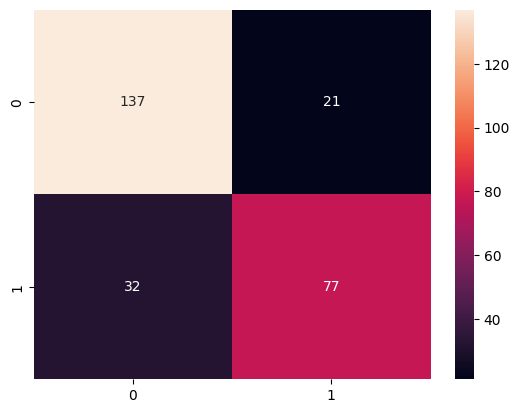

In [111]:
print(confusion_matrix(y_test, predictions))

# if you want a more graphical version of this, try:
# the fmt-parameter will change to decimal format from scientific format
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')

In [112]:
# The AUC score is a super sensitive metric
# you often get low scores, even 0.5

# in binary logistic regression, AUC values are often interpreted as follows:
# A binary classifier is useful only when it achieves ROC-AUC score greater than 0.5 and as near to 1 as possible. 
# If a classifier yields a score less than 0.5, it simply means that the model is performing worse 
# than a random classifier, and therefore is useless.

# In multinomial logistic regression , AUC values are often interpreted as follows: 
# 0.5-0.6 (failed)
# 0.6-0.7 (worthless)
# 0.7-0.8 (poor)
# 0.8-0.9 (good)
# > 0.9 (excellent)

# basically 0.5 means, there's still something to optimize
# if this falls under 0.5, random guessing works better than this model
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# ~83-84%, which is pretty OK

0.869353152943909

#### Let's try using the model in deciding a new imaginary person and if they survived or not

In [113]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked_C', 'Embarked_Q'],
      dtype='str')

In [114]:
df.head(1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q
0,0,3,1,22.0,1,0,7.25,0,0


In [115]:
# Sex -column: 0 => Female, 1 => Male
tester_row = {
    'Pclass': 3, 
    'Sex': 0, 
    'Age': 22, 
    'SibSp': 1, 
    'Parch': 0, 
    'Fare': 7.25,
    'Embarked_C': 0,
    'Embarked_Q': 0
}

# create a pandas DataFrame and scale the values
tester_row = pd.DataFrame([tester_row])
tester_row = sc.transform(tester_row)

print("All probabilities by category:")
print(model.predict_proba(tester_row))
print()

# change these based on your original data
labels = ["No", "Yes"]

print("Did this passenger survive the Titanic (No/Yes):")
result = labels[model.predict(tester_row)[0]]
print(result)
print("-------------------")

All probabilities by category:
[[0.38702445 0.61297555]]

Did this passenger survive the Titanic (No/Yes):
Yes
-------------------
